## Weight  of evidence



Weight of Evidence (WoE) was developed primarily for the credit and financial industries to help build more predictive models to evaluate the risk of loan default. That is, to predict how likely the money lent to a person or institution is to be lost. Thus, Weight of Evidence is a measure of the "strength” of a grouping technique to separate good and bad risk (default). 

- WoE will be 0 if the P(Goods) / P(Bads) = 1, that is, if the outcome is random for that group.
- If P(Bads) > P(Goods) the odds ratio will be < 1 and,
- WoE will be < 0 if,  P(Goods) > P(Bads).

WoE is well suited for Logistic Regression, because the Logit transformation is simply the log of the odds, i.e., ln(P(Goods)/P(Bads)). Therefore, by using WoE-coded predictors in logistic regression, the predictors are all prepared and coded to the same scale, and the parameters in the linear logistic regression equation can be directly compared.

The WoE transformation has three advantages:

- It creates a monotonic relationship between the target and the independent variables.
- It orders the categories on a "logistic" scale which is natural for logistic regression
- The transformed variables can then be compared because they are on the same scale. Therefore, it is possible to determine which one is more predictive.

The WoE also has a limitation:

- Prone to cause over-fitting


For more details follow this [article](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html#Steps-of-Calculating-WOE).


## In this demo:

We will see how to perform one hot encoding with pandas using the Titanic dataset.

For guidelines to obtain the dataset, visit **section 2** of the course.

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# to split the datasets
from sklearn.model_selection import train_test_split

In [92]:
# load dataset
#using 3 categorical variable and target survived
data = pd.read_csv(
    "../../Datasets/titanic.csv", usecols=["cabin", "sex", "embarked", "survived"]
)

data.head()

,survived,sex,cabin,embarked
0,1,female,B5,S
1,1,male,C22,S
2,0,female,C22,S
3,0,male,C22,S
4,0,female,C22,S


In [93]:
# let's remove observations with na in embarked

data.dropna(subset=["embarked"], inplace=True) # remove missing one
data.shape

(1307, 4)

In [94]:
# Now we extract the first letter of the cabin
# to create a simpler variable for the demo

data["cabin"] = data["cabin"].astype(str).str[0] #returing first letter of cabin. Ex C22 to C

In [95]:
# and we remove the observations where cabin = T
# because only few observations show T in the dataset

data = data[data["cabin"] != "T"] # We manually checked that, cabin T had very few customers. So, removing it so that, we don't face issues in testing later (cz we may not have any T cabin custom in training but we may have them in testing. So, it will create issues)
data.shape

(1306, 4)

In [96]:
# let's have a look at how many labels each variable has
#cardinality : each column has how many different values

for col in data.columns:
    print(col, ": ", len(data[col].unique()), " labels")

survived :  2  labels
sex :  2  labels
cabin :  8  labels
embarked :  3  labels


In [97]:
# let's explore the unique categories
data["cabin"].unique() # 8 labels of cabin column are 'B', 'C', 'E', 'D', 'A', 'n', 'F', 'G'

array(['B', 'C', 'E', 'D', 'A', 'n', 'F', 'G'], dtype=object)

In [98]:
data["sex"].unique() # 2 labels of the sex column

array(['female', 'male'], dtype=object)

In [99]:
data["embarked"].unique() # 3 labels of the embarked column

array(['S', 'C', 'Q'], dtype=object)

### Encoding important

We select calculate the woe using the train set, and then use those mappings in the test set.

Note that in the pandas implementation, we need to keep the target in the training set

In [100]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[["cabin", "sex", "embarked", "survived"]],  # this time we keep the target!!
    data["survived"],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0,
)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((914, 4), (392, 4))

### Explore original relationship between categorical variables and target

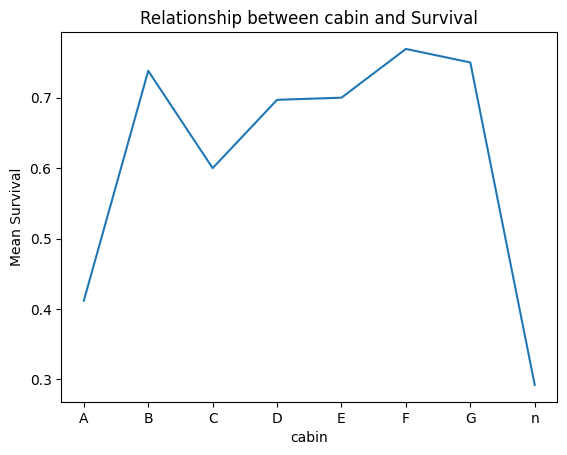

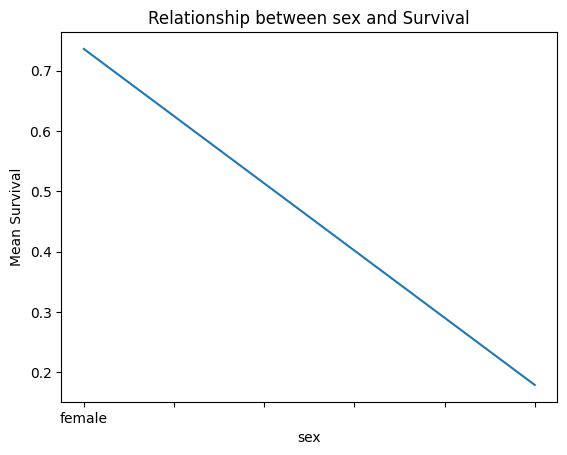

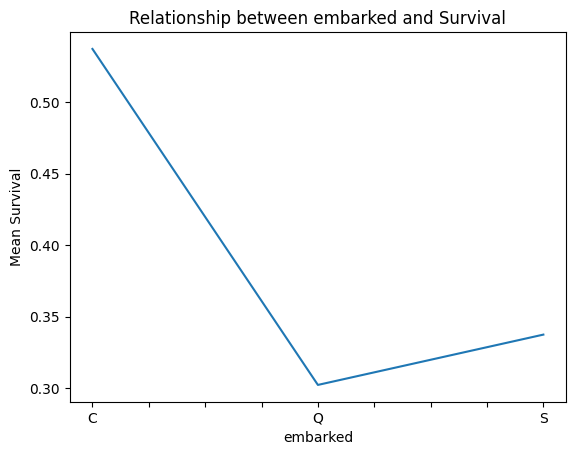

In [ ]:
# let's explore the relationship of the categories with the target

# as Weight of Evidence can return a monotonic relation with the target column, let's check that here

# so, relation between cabin vs survived; sex vs survived, embarked vs survived


for var in ["cabin", "sex", "embarked"]:
    #y_train= survived
    fig = plt.figure()
    fig = y_train.groupby(X_train[var]).mean().plot()
    fig.set_title("Relationship between {} and Survival".format(var))
    fig.set_ylabel("Mean Survival")
    plt.show()

You can see that the relationship between the target and cabin and embarked goes up and down, depending on the category.


## Weight of Evidence with pandas


### Advantages

- quick
- returns pandas dataframe

### Limitations of pandas:

- it does not preserve information from train data to propagate to test data

We need to store the mappings separately if planning to use the model in production.

In [ ]:
# let's calculate the proportion of passengers who survived
# over the total survivors, per category of cabin

# total survivors

# we kept survived this time in X_train for the calculation.
total_survived = X_train["survived"].sum() #total survived

# percentage of passenges who survived, from total survivors
# per category of cabin

#summing survivors per cabin & then dividing by total to get the average survived person per cabin.

survived = X_train.groupby(["cabin"])["survived"].sum() / total_survived

survived

cabin
A    0.020408
B    0.090379
C    0.122449
D    0.067055
E    0.061224
F    0.029155
G    0.008746
n    0.600583
Name: survived, dtype: float64

In [ ]:
# let's calculate the proportion of passengers who did not survive
# over the total passengers who didn't, per category of cabin

# total passengers who did not survive
total_non_survived = len(X_train) - X_train["survived"].sum()

# let's create a flag variable for passenges who did not survive
X_train["non_survived"] = np.where(X_train["survived"] == 1, 0, 1) # when we have 1 for survived, we will assign non_survived 0 

# now let's calculate the % of passengers who did not survive
# per category of cabin
non_survived = X_train.groupby(["cabin"])["non_survived"].sum() / total_non_survived

non_survived

cabin
A    0.017513
B    0.019264
C    0.049037
D    0.017513
E    0.015762
F    0.005254
G    0.001751
n    0.873905
Name: non_survived, dtype: float64

In [ ]:
#  now let's combine those 2 series in a dataframe and calculate the WoE for the cabin column

# let's concatenate the series in a dataframe
prob_df = pd.concat([survived, non_survived], axis=1)

# let's calculate the Weight of Evidence
prob_df["woe"] = np.log(prob_df["survived"] / prob_df["non_survived"])

prob_df

,survived,non_survived,woe
cabin,,,
A,0.020408,0.017513,0.152984
B,0.090379,0.019264,1.545751
C,0.122449,0.049037,0.915124
D,0.067055,0.017513,1.342568
E,0.061224,0.015762,1.356957
F,0.029155,0.005254,1.713632
G,0.008746,0.001751,1.608271
n,0.600583,0.873905,-0.375071


In [105]:
# and now let's capture the woe in a dictionary

ordered_labels = prob_df["woe"].to_dict()

ordered_labels

{'A': 0.1529838185513379,
 'B': 1.545750694176846,
 'C': 0.9151238705982346,
 'D': 1.3425678854251744,
 'E': 1.356956622877274,
 'F': 1.7136315668160063,
 'G': 1.60827105115818,
 'n': -0.37507116447186734}

In [ ]:
# now, we replace the labels with the woe
# now we use the WOE value with cabin's value in test and training set.


X_train["cabin"] = X_train["cabin"].map(ordered_labels) #for training set
X_test["cabin"] = X_test["cabin"].map(ordered_labels) #for test dataset

In [ ]:
# let's explore the result

X_train["cabin"].head(10) #check the first 10 values.

843    -0.375071
869    -0.375071
430    -0.375071
481    -0.375071
1308   -0.375071
456    -0.375071
118     1.342568
485     1.342568
297    -0.375071
263     1.356957
Name: cabin, dtype: float64

In [ ]:
# we can turn the previous commands into 2 functions

#making a function to ease the process

def find_category_mappings(df, variable, target):

    # copy of the original dataframe, so we do not accidentally
    # modify it
    tmp = df.copy()

    # total positive class
    total_pos = df[target].sum()

    # total negative class
    total_neg = len(df) - df[target].sum()

    # non target
    tmp["non-target"] = 1 - tmp[target]

    # % of positive class per category, respect to total positive class
    pos_perc = tmp.groupby([variable])[target].sum() / total_pos

    # % of negative class per category, respect to total negative class
    neg_perc = tmp.groupby([variable])["non-target"].sum() / total_neg

    # let's concatenate
    prob_tmp = pd.concat([pos_perc, neg_perc], axis=1)

    # let's calculate the Weight of Evidence
    prob_tmp["woe"] = np.log(prob_tmp[target] / prob_tmp["non-target"])

    return prob_tmp["woe"].to_dict()


def integer_encode(train, test, variable, ordinal_mapping):

    train[variable] = train[variable].map(ordinal_mapping)

    test[variable] = test[variable].map(ordinal_mapping)

In [ ]:
# WOE now for the remaining 2 categorical columns
for variable in ["sex", "embarked"]:

    mappings = find_category_mappings(X_train, variable, "survived")

    integer_encode(X_train, X_test, variable, mappings)

In [110]:
# let's see the result

X_train.head()

,cabin,sex,embarked,survived,non_survived
843,-0.375071,-1.013111,-0.164796,0,1
869,-0.375071,-1.013111,-0.164796,0,1
430,-0.375071,1.535068,-0.164796,1,0
481,-0.375071,1.535068,0.658871,1,0
1308,-0.375071,-1.013111,-0.164796,0,1


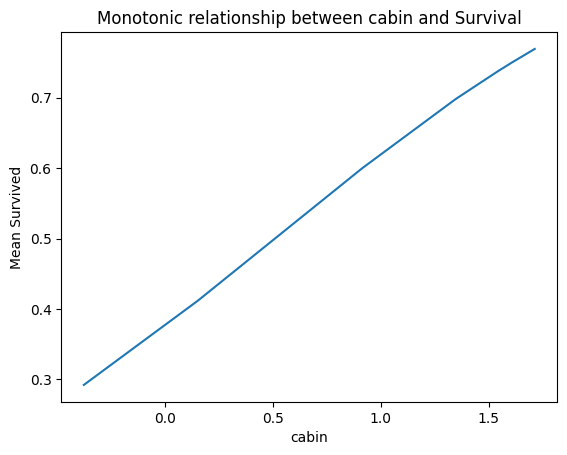

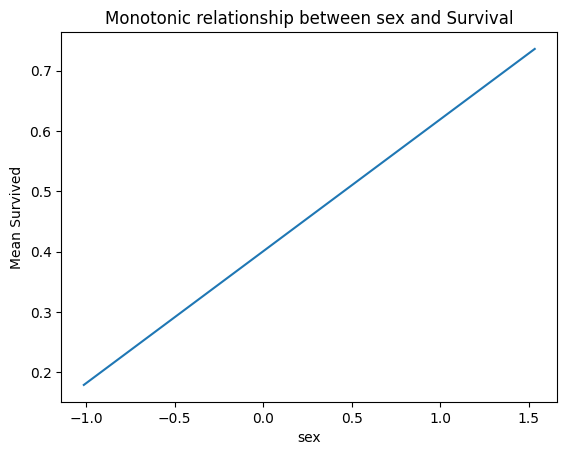

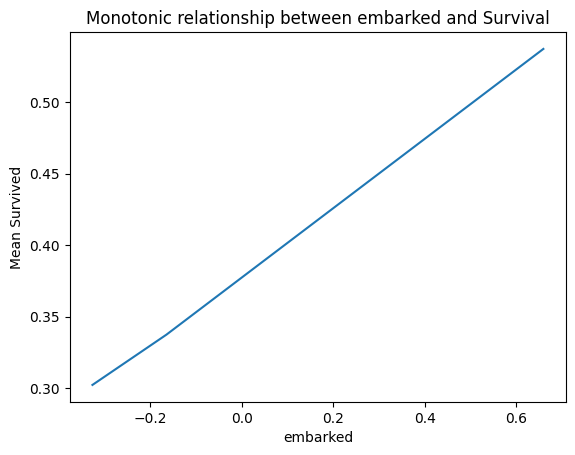

In [ ]:
# now let's try to find a monotonic connection between the categorical columns and survived column for training data


for var in ["cabin", "sex", "embarked"]:

    fig = plt.figure()
    fig = X_train.groupby([var])["survived"].mean().plot()
    fig.set_title("Monotonic relationship between {} and Survival".format(var))
    fig.set_ylabel("Mean Survived")
    plt.show()

# so, we can see a linear relation for each pair

Note the monotonic relationships between the mean target and the categories. In the train set.

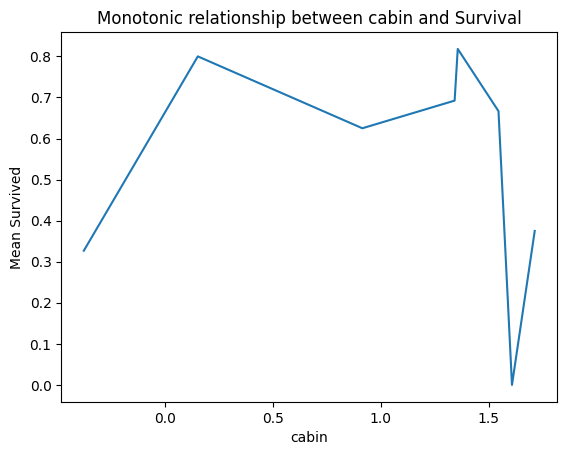

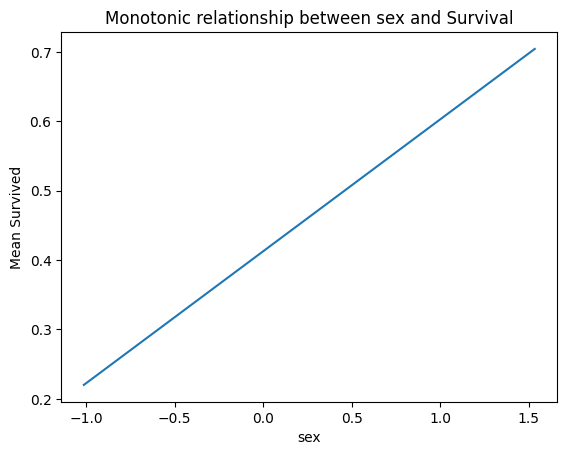

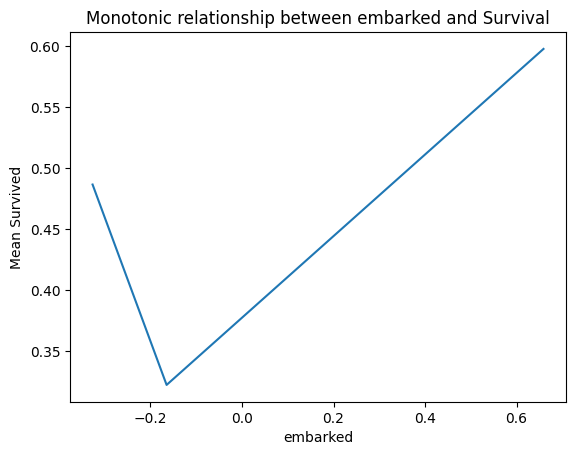

In [ ]:
# now in the test set
#this time we can't see that linear relation meaning we are not finding any pattern.

for var in ["cabin", "sex", "embarked"]:

    fig = plt.figure()
    fig = X_test.groupby([var])["survived"].mean().plot()
    fig.set_title("Monotonic relationship between {} and Survival".format(var))
    fig.set_ylabel("Mean Survived")
    plt.show()

The monotonic relationship does not hold when encoding the categorical variables in the test set. This could mean that the categories are not informative of the target or the proportion of survivors is not homogeneous between in the categories in the train and test sets. 

In situations like this, we could try grouping rare labels into a joint category as we will cover later in this section, before applying the Weight of evidence transformation.

### Note

Replacing categorical labels with this code and method will generate missing values for categories present in the test set that were not seen in the training set. Therefore it is extremely important to handle rare labels before-hand. I will explain how to do this, in a later notebook.

**In addition, it will create NA or Inf if any of the 2 terms in the ratio of the WoE formula are 0**